Task III:

The electron-photon dataset (which can be found here) contains 100 samples for training and another 100 for testing, laid out as follows:

● data["x_train"]: Training dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_train"]:" Training labels, 0 = "photon", 1 = "electron" (100,)

● data["x_test"]: Test dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_test"]:" Test labels, 0 = "photon", 1 = "electron" (100,)

The dataset labels are labelled 0 for photons and 1 for electrons.

Your task is to

Part b) implement a quantum neural network of any architecture (except convolutional) in Tensorflow Quantum

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/gopald/.local/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# visualization tools
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2022-04-23 22:16:03.023095: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-23 22:16:03.023150: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhagvada): /proc/driver/nvidia/version does not exist
2022-04-23 22:16:03.046228: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the dataset
dataset = np.load('./data/electron-photon.npz',allow_pickle=True)

In [47]:
# Unpack the train and test values
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test']

# Check the shapes of training and test datasets
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.max() , x_train.min())
print(x_test.max(), x_test.min())

(100, 32, 32) (100,)
(100, 32, 32) (100,)
1.4274136 0.0
1.392017 0.0


Since the dataset contains only 100 samples, lets plot them all to see if we can find something meaningful.

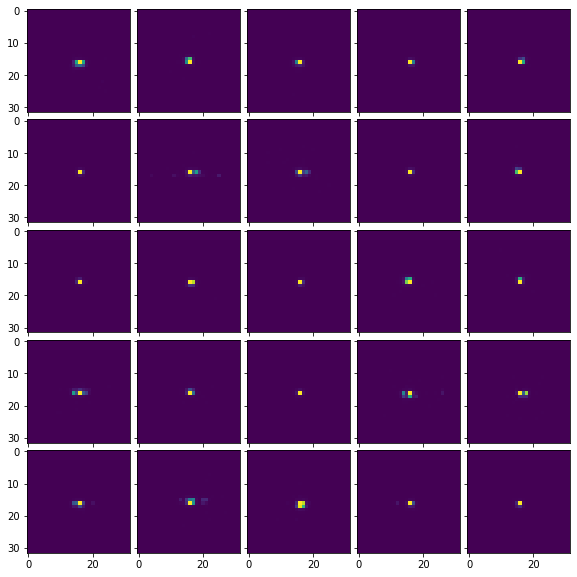

In [48]:
fig = plt.figure(figsize=(10, 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, x_train[:25]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

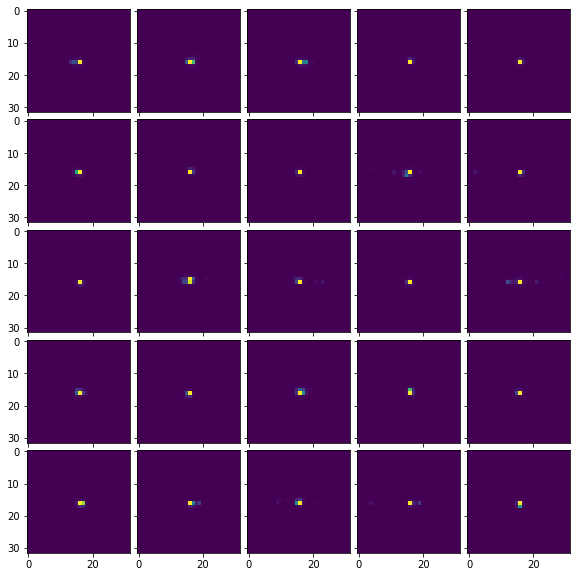

In [49]:
fig = plt.figure(figsize=(10, 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, x_train[25:50]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

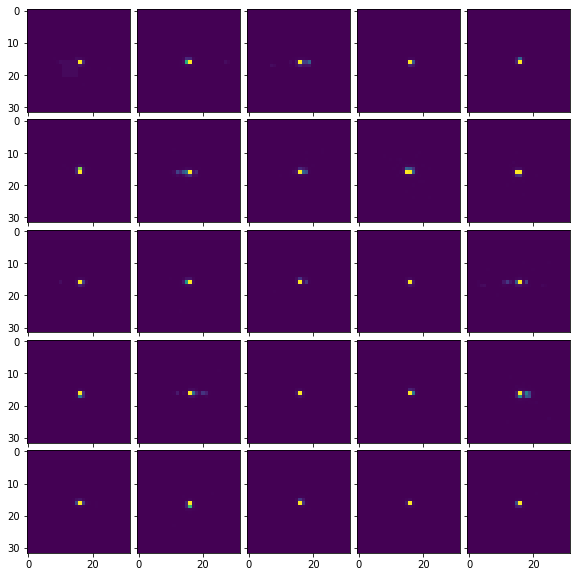

In [50]:
fig = plt.figure(figsize=(10, 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, x_train[50:75]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

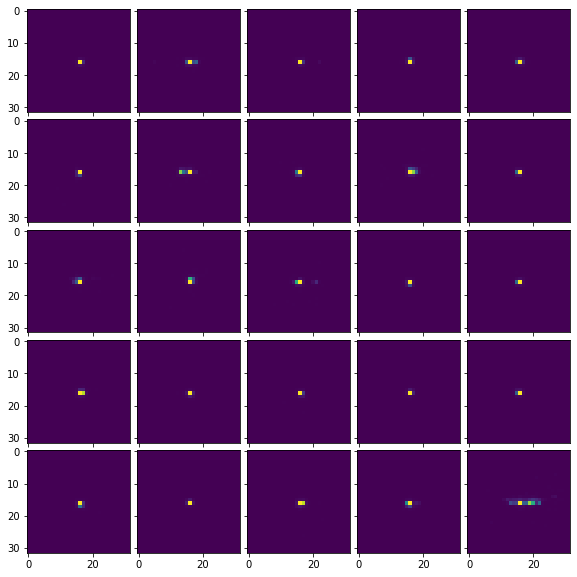

In [51]:
fig = plt.figure(figsize=(10, 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, x_train[75:100]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

Normalize the training and test datasets

In [52]:
# Rescale the images to the [0.0,1.0] range.
train_max = x_train.max()
test_max = x_test.max()
x_train_scaled, x_test_scaled = x_train[..., np.newaxis]/train_max, x_test[..., np.newaxis]/test_max

print(x_train_scaled.shape, y_train.shape)
print(x_test_scaled.shape, y_test.shape)

# Check the min and max values in the datasets
print(x_train_scaled.max() , x_train.min())
print(x_test_scaled.max(), x_test.min())

(100, 32, 32, 1) (100,)
(100, 32, 32, 1) (100,)
1.0 0.0
1.0 0.0


Let's see the number of photons and electrons in the dataset. 

In [53]:
print((y_train == 1).sum(), (y_train == 0).sum())
print((y_test == 1).sum() , (y_test == 0).sum())

56 44
46 54


In [54]:
y_train

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

We can see that the dataset contains almost equal number of images for photons and electrons i.e. the dataest is balanced. We need not need to create duplicate images or reduce the size of the dataset.

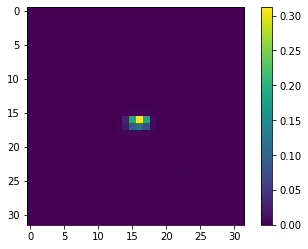

In [55]:
plt.imshow(x_train[0]) # class 1
plt.colorbar()

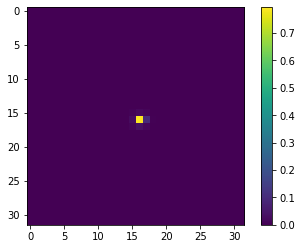

In [56]:
plt.imshow(x_train[5]) # class 0
plt.colorbar()

An image size of 32x32  is much too large for current quantum computers. Resize the image down to 4x4.

In [57]:
# Resize images to 4 by 4
x_train_small = tf.image.resize(x_train_scaled, (4,4),method='nearest').numpy()
x_test_small = tf.image.resize(x_test_scaled, (4,4),method='nearest').numpy()

train_small_max = x_train_small.max()
test_small_max = x_test_small.max()
x_train_small, x_test_small = x_train_small/train_small_max, x_test_small/test_small_max

print(x_train_small.shape, x_test_small.shape)
print(x_train_small.max() , x_train_small.min())
print(x_test_small.max(), x_test_small.min())

(100, 4, 4, 1) (100, 4, 4, 1)
1.0 0.0
1.0 0.0


To process images using a quantum computer, [Farhi et al.](https://arxiv.org/pdf/1802.06002.pdf) proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [58]:
# binary encoding
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)


print(x_train_bin.shape, y_train.shape)
print(x_test_bin.shape, y_test.shape)

(100, 4, 4, 1) (100,)
(100, 4, 4, 1) (100,)


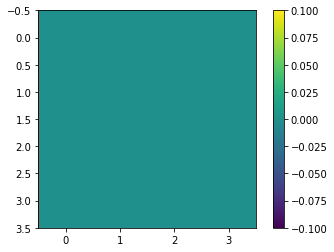

In [59]:
plt.imshow(x_train_small[0,:,:,0]) # class 1
plt.colorbar()

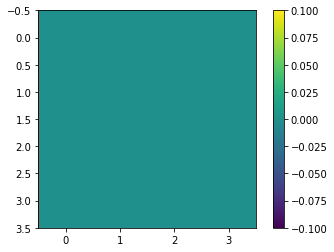

In [60]:
plt.imshow(x_train_small[5,:,:,0]) # class 0
plt.colorbar()

As we can see that the reduction does not preserve the features of the images. The image of a photon and electron has become same and thus the quantum circuit after encoding with such data will not predict correctly.

Principal Component analysis (PCA) is used for dimensionality reduction of data with high number of features. One has to make sure that the variance of the data after PCA should not change much. We try to plot cumulative sum of variance and see the results. 

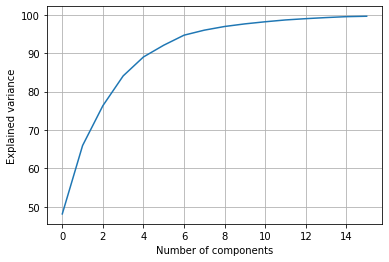

In [61]:
pca_16 = PCA(n_components=16) # Try PCA with 16 components
pca_16.fit(x_train.reshape(100, 32*32))

plt.grid()
plt.plot(np.cumsum(pca_16.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

In [62]:
np.cumsum(pca_16.explained_variance_ratio_ * 100)[-1]

99.63432

We can see that almost 99% of the variance of the original dataset is preserved in the dataset after PCA. This means that the 16 features can explain almost 99% variance of the original dataset.

In [63]:
# Fit PCA
x_train_reduced = pca_16.fit_transform(x_train.reshape(100, 32*32)) 
x_test_reduced = pca_16.fit_transform(x_train.reshape(100, 32*32))

In [64]:
print(x_train_reduced.shape)
print(x_test_reduced.shape)

(100, 16)
(100, 16)


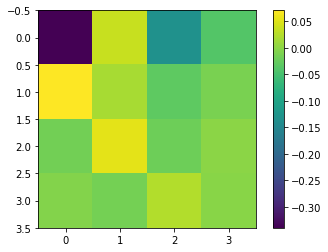

In [65]:
plt.imshow(x_train_reduced.reshape(100,4,4)[0])# class 1
plt.colorbar()

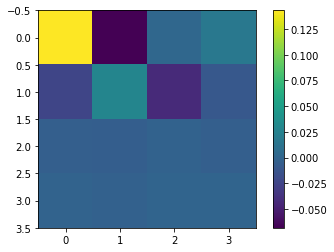

In [66]:
plt.imshow(x_train_reduced.reshape(100,4,4)[5])# class 0
plt.colorbar()

In [67]:
# Rescale the images to the [0.0,1.0] range.
x_train = normalize(x_train_reduced)
x_test = normalize(x_test_reduced)

print(x_train.max() , x_train.min())
print(x_test.max(), x_test.min())

0.9941799 -0.88755774
0.99417996 -0.8875578


Perform binary encoding

In [68]:
THRESHOLD = 0

x_train_bin = np.array(x_train > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [69]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(image):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

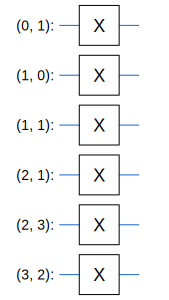

In [70]:
SVGCircuit(x_train_circ[0]) # class 1

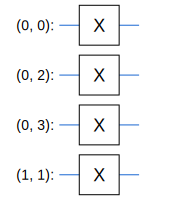

In [72]:
SVGCircuit(x_train_circ[5]) # class 0

Convert these Cirq circuits to tensors for tfq

In [84]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

Following the [MNIST tutorial](https://www.tensorflow.org/quantum/tutorials/mnist) by Tensorflow quantum. 

We follow a layered approach. Each layer uses $n$ instances of the same gate, with each of the data qubits acting on the readout qubit.

We start with a simple class that will add a layer of these gates to a circuit.

In [73]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits 
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

We build a three-layered model.

In [101]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers.
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    builder.add_layer(circuit, cirq.XX, "xx2")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

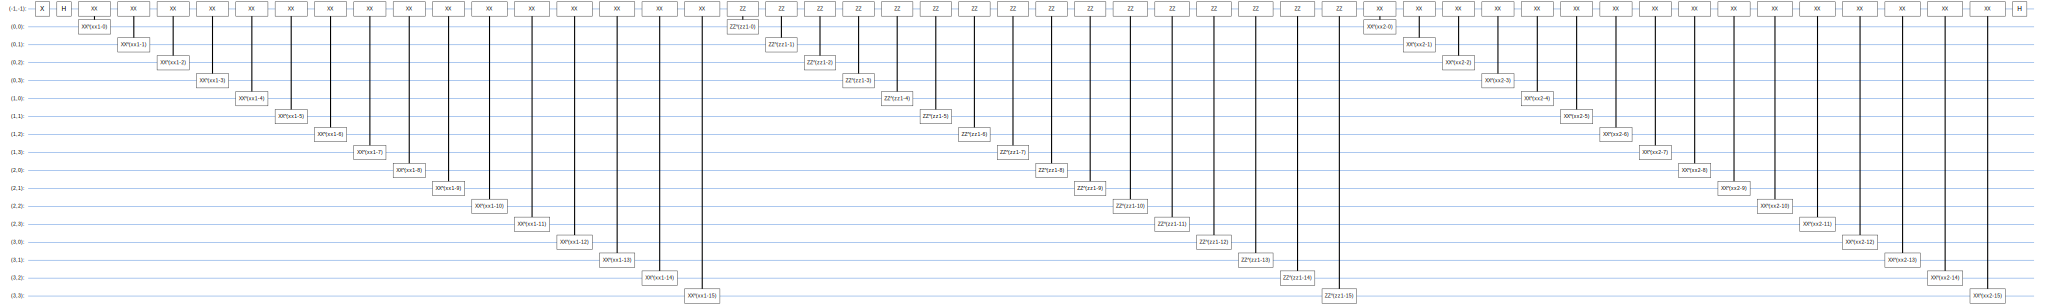

In [102]:
model_circuit, model_readout = create_quantum_model()
SVGCircuit(model_circuit)

Build the Keras model with the quantum components. The "quantum data", from x_train_circ, that encodes the classical data is then fed into this Keras model. It uses a Parametrized Quantum Circuit layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, [Farhi et al.](https://arxiv.org/pdf/1802.06002.pdf) proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [103]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Since the the expected readout is in the range [-1,1], we use the hinge loss. To use the hinge loss we need convert the labels, from boolean to [-1,1], as expected by the hinge loss.

In [104]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [105]:
y_train_hinge

array([ 1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.], dtype=float32)

We build a custiom hinge_accuracy metric that correctly handles [-1, 1] as the y_true labels argument.

In [106]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

Compile the model

In [107]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [108]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 48        
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
EPOCHS = 100 # Number of epochs
BATCH_SIZE = 32 # The size of the batch

NUM_EXAMPLES = len(x_train_tfcirc) # Number of samples in the training dataset

print(EPOCHS, BATCH_SIZE, NUM_EXAMPLES)

100 32 100


Training the model

In [110]:
qnn_history = model.fit(
      x_train_tfcirc, y_train_hinge,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 1.0151 - hinge_accuracy: 0.4609 - val_loss: 1.0097 - val_hinge_accuracy: 0.4375
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 1.0118 - hinge_accuracy: 0.4609 - val_loss: 1.0097 - val_hinge_accuracy: 0.4453
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 1.0101 - hinge_accuracy: 0.5938 - val_loss: 1.0098 - val_hinge_accuracy: 0.4453
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 1.0078 - hinge_accuracy: 0.3750 - val_loss: 1.0102 - val_hinge_accuracy: 0.4453
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 1.0059 - hinge_accuracy: 0.4922 - val_loss: 1.0102 - val_hinge_accuracy: 0.4375
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 1.0042 - hinge_accuracy: 0.4375 - val_loss: 1.0102 - val_hinge_accuracy: 0.4297
Epoch 7/100
4/4 [==============================] - 13s 3s/step - loss: 1.0023 - hinge_accuracy: 0.53

4/4 [==============================] - 11s 3s/step - loss: 0.8194 - hinge_accuracy: 0.7188 - val_loss: 0.9766 - val_hinge_accuracy: 0.4922
Epoch 56/100
4/4 [==============================] - 11s 3s/step - loss: 0.8150 - hinge_accuracy: 0.7188 - val_loss: 0.9747 - val_hinge_accuracy: 0.4922
Epoch 57/100
4/4 [==============================] - 9s 2s/step - loss: 0.8098 - hinge_accuracy: 0.6641 - val_loss: 0.9730 - val_hinge_accuracy: 0.4922
Epoch 58/100
4/4 [==============================] - 10s 3s/step - loss: 0.8049 - hinge_accuracy: 0.7188 - val_loss: 0.9717 - val_hinge_accuracy: 0.4922
Epoch 59/100
4/4 [==============================] - 11s 2s/step - loss: 0.8012 - hinge_accuracy: 0.6719 - val_loss: 0.9694 - val_hinge_accuracy: 0.5000
Epoch 60/100
4/4 [==============================] - 11s 3s/step - loss: 0.7962 - hinge_accuracy: 0.6719 - val_loss: 0.9682 - val_hinge_accuracy: 0.5000
Epoch 61/100
4/4 [==============================] - 11s 3s/step - loss: 0.7920 - hinge_accuracy: 0.671

Plot the results.

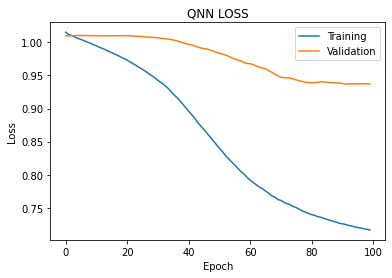

In [111]:
plt.plot(qnn_history.history['loss'], label='Training')
plt.plot(qnn_history.history['val_loss'], label='Validation')
plt.title('QNN LOSS')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

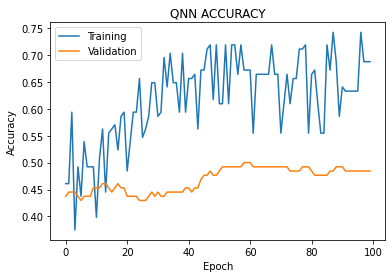

In [112]:
plt.plot(qnn_history.history['hinge_accuracy'], label='Training')
plt.plot(qnn_history.history['val_hinge_accuracy'], label='Validation')
plt.title('QNN ACCURACY')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Conclusion

We built a QNN using Cirq and Tensorflow. The training loss shows a downtrend which means that the model fits the data well and also the validation loss decreases gradually which means that the model will predict well on the data which has not been shown to it. Since the size of the dataset is small, this is bound to happen. 
    
To increase the accurracy and generalize the model well we need to increase the size of the dataset. Also since the number of features are 32x32 and we used only 16 qubits, we need to account for this as well. We used basis encoding for encoding the data but for large number of features we can use the amplitude encoding scheme which uses lesser number of qubits ($log_2N$ where $N$ is the number of features in a feature vector).